<a href="https://colab.research.google.com/github/spshreya/Data_science_projects/blob/main/demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools
import holidays

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Reading the data

In [64]:
train_df = pd.read_csv('train.csv')

In [3]:
test_df = pd.read_csv('test.csv')

## Exploratory Data Analysis

In [6]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [7]:
test_df.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [65]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [66]:
#setting id as index
train_df.set_index('id', inplace=True)

In [12]:
train_df.date.min()

Timestamp('2010-01-01 00:00:00')

In [13]:
train_df.date.max()

Timestamp('2016-12-31 00:00:00')

In [14]:
train_df.country.value_counts()

,count
country,
Canada,38355
Finland,38355
Italy,38355
Kenya,38355
Norway,38355
Singapore,38355


In [16]:
train_df.store.value_counts()

,count
store,
Discount Stickers,76710
Stickers for Less,76710
Premium Sticker Mart,76710


In [19]:
train_df['product'].value_counts()

,count
product,
Holographic Goose,46026
Kaggle,46026
Kaggle Tiers,46026
Kerneler,46026
Kerneler Dark Mode,46026


In [20]:
df_grouped = train_df.groupby(['country', 'store', 'product'])['num_sold'].sum().reset_index()
df_grouped

,country,store,product,num_sold
0,Canada,Discount Stickers,Holographic Goose,0.0
1,Canada,Discount Stickers,Kaggle,1829924.0
2,Canada,Discount Stickers,Kaggle Tiers,1515225.0
3,Canada,Discount Stickers,Kerneler,827127.0
4,Canada,Discount Stickers,Kerneler Dark Mode,965988.0
...,...,...,...,...
85,Singapore,Stickers for Less,Holographic Goose,586737.0
86,Singapore,Stickers for Less,Kaggle,4201315.0
87,Singapore,Stickers for Less,Kaggle Tiers,3469701.0
88,Singapore,Stickers for Less,Kerneler,1895672.0


In [22]:
df_grouped.sort_values(by='num_sold', ascending=False)

,country,store,product,num_sold
66,Norway,Premium Sticker Mart,Kaggle,8177022.0
71,Norway,Stickers for Less,Kaggle,6917719.0
67,Norway,Premium Sticker Mart,Kaggle Tiers,6757456.0
72,Norway,Stickers for Less,Kaggle Tiers,5717409.0
81,Singapore,Premium Sticker Mart,Kaggle,4955153.0
...,...,...,...,...
48,Kenya,Discount Stickers,Kerneler,18902.0
50,Kenya,Premium Sticker Mart,Holographic Goose,11355.0
55,Kenya,Stickers for Less,Holographic Goose,6559.0
0,Canada,Discount Stickers,Holographic Goose,0.0


In [23]:
df_grouped.num_sold.describe()

,num_sold
count,9.000000e+01
mean,1.850038e+06
std,1.727954e+06
min,0.000000e+00
25%,4.852760e+05
50%,1.529175e+06
75%,2.779639e+06
max,8.177022e+06


In [26]:
train_df.groupby(['country'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,country,num_sold
4,Norway,54562305.0
5,Singapore,33102374.0
1,Finland,28698872.0
0,Canada,28653095.0
2,Italy,20797669.0
3,Kenya,689141.0


In [27]:
train_df.groupby(['country', 'store'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,country,store,num_sold
13,Norway,Premium Sticker Mart,24084870.0
14,Norway,Stickers for Less,20396815.0
16,Singapore,Premium Sticker Mart,14611960.0
1,Canada,Premium Sticker Mart,12832976.0
4,Finland,Premium Sticker Mart,12675641.0
17,Singapore,Stickers for Less,12370921.0
5,Finland,Stickers for Less,10723058.0
2,Canada,Stickers for Less,10681855.0
12,Norway,Discount Stickers,10080620.0
7,Italy,Premium Sticker Mart,9188782.0


In [31]:
train_df.groupby(['store'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,store,num_sold
1,Premium Sticker Mart,73703822.0
2,Stickers for Less,62200397.0
0,Discount Stickers,30599237.0


In [32]:
train_df.groupby(['product'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,product,num_sold
1,Kaggle,56721733.0
2,Kaggle Tiers,46870306.0
4,Kerneler Dark Mode,29964209.0
3,Kerneler,25596840.0
0,Holographic Goose,7350368.0


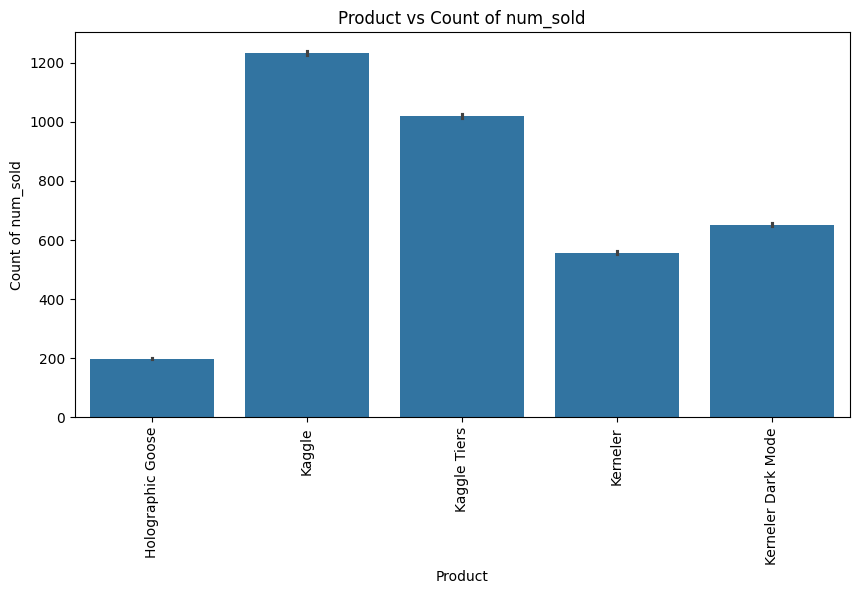

In [34]:
#plot for product and count of num_sold
plt.figure(figsize=(10, 5))
sns.barplot(data=train_df, x='product', y='num_sold')
plt.xlabel('Product')
plt.ylabel('Count of num_sold')
plt.title('Product vs Count of num_sold')
plt.xticks(rotation=90)
plt.show()

In [36]:
train_df.num_sold.describe()

,num_sold
count,221259.000000
mean,752.527382
std,690.165445
min,5.000000
25%,219.000000
50%,605.000000
75%,1114.000000
max,5939.000000


### Exploring Nans in num_sold

In [39]:
total_nans = train_df['num_sold'].isna().sum()
percent_nans = (total_nans / len(train_df)) * 100
print(f"Total NaNs in 'num_sold': {total_nans}")
print(f"Percentage of NaNs in 'num_sold': {percent_nans:.2f}%")

Total NaNs in 'num_sold': 8871
Percentage of NaNs in 'num_sold': 3.85%


In [42]:
country_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('country').size().reset_index(name='nan_count')
print(country_nan_analysis)

  country  nan_count
0  Canada       4246
1   Kenya       4625


In [43]:
store_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('store').size().reset_index(name='nan_count')
print(store_nan_analysis)

                  store  nan_count
0     Discount Stickers       5179
1  Premium Sticker Mart       1026
2     Stickers for Less       2666


In [44]:
product_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('product').size().reset_index(name='nan_count')
print(product_nan_analysis)

              product  nan_count
0   Holographic Goose       8806
1            Kerneler         64
2  Kerneler Dark Mode          1


In [47]:
date_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('date').size().reset_index(name='nan_count').sort_values(by='nan_count', ascending=False)
date_nan_analysis

,date,nan_count
110,2010-04-21,7
90,2010-04-01,7
130,2010-05-11,7
151,2010-06-01,7
204,2010-07-24,6
...,...,...
1527,2014-03-08,2
1528,2014-03-09,2
1529,2014-03-10,2
1530,2014-03-11,2


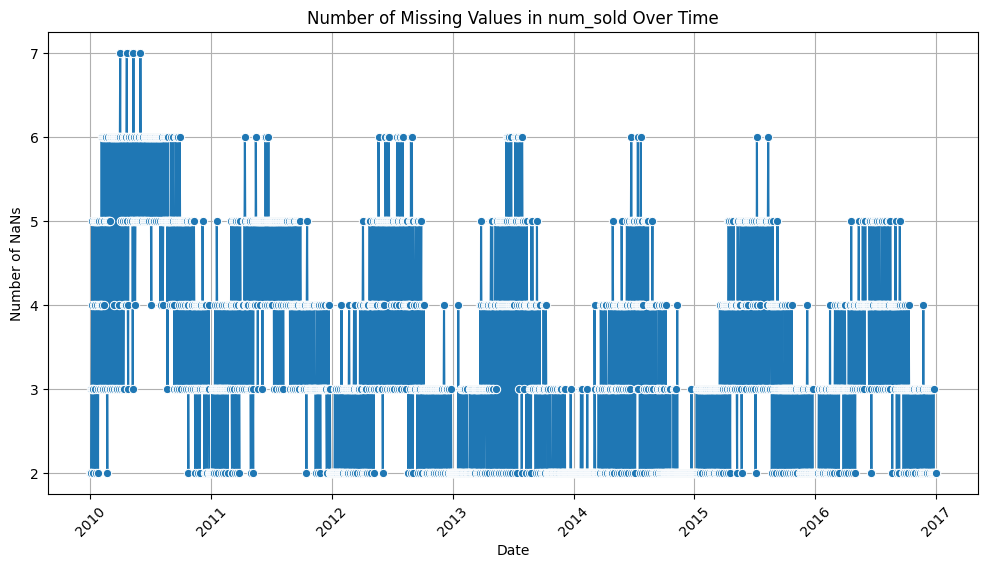

In [52]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=date_nan_analysis, x='date', y='nan_count', marker='o')
plt.title('Number of Missing Values in num_sold Over Time')
plt.xlabel('Date')
plt.ylabel('Number of NaNs')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [67]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek  # Monday=0, Sunday=6
train_df['week_of_year'] = train_df['date'].dt.isocalendar().week

In [68]:
train_df.head()

,date,country,store,product,num_sold,year,month,day,day_of_week,week_of_year
id,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,4,53
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,53
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,53
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,53
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,53


In [69]:
date_nan_count = train_df[train_df['num_sold'].isna()].groupby('date').size().reset_index(name='nan_count')
print(date_nan_count.head())

        date  nan_count
0 2010-01-01          2
1 2010-01-02          2
2 2010-01-03          2
3 2010-01-04          3
4 2010-01-05          3


In [81]:
year_nan_count = train_df[train_df['num_sold'].isna()].groupby('year').size().reset_index(name='nan_count')
print(year_nan_count.sort_values(by='nan_count', ascending=False))

   year  nan_count
0  2010       1709
1  2011       1405
2  2012       1221
5  2015       1207
6  2016       1173
3  2013       1129
4  2014       1027


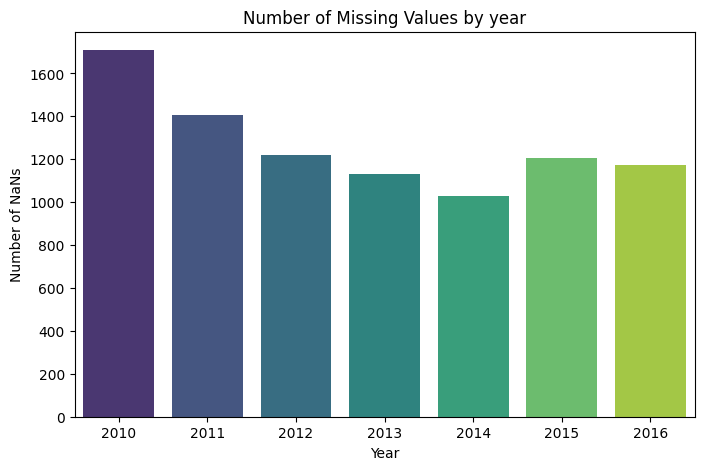

In [82]:
plt.figure(figsize=(8, 5))
sns.barplot(data=year_nan_count, x='year', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by year')
plt.xlabel('Year')
plt.ylabel('Number of NaNs')
plt.show()

In [72]:
month_nan_count = train_df[train_df['num_sold'].isna()].groupby('month').size().reset_index(name='nan_count')
print(month_nan_count.sort_values(by='nan_count', ascending=False))

    month  nan_count
6       7        985
5       6        942
7       8        920
4       5        896
3       4        771
8       9        751
2       3        721
9      10        654
10     11        576
1       2        564
0       1        555
11     12        536


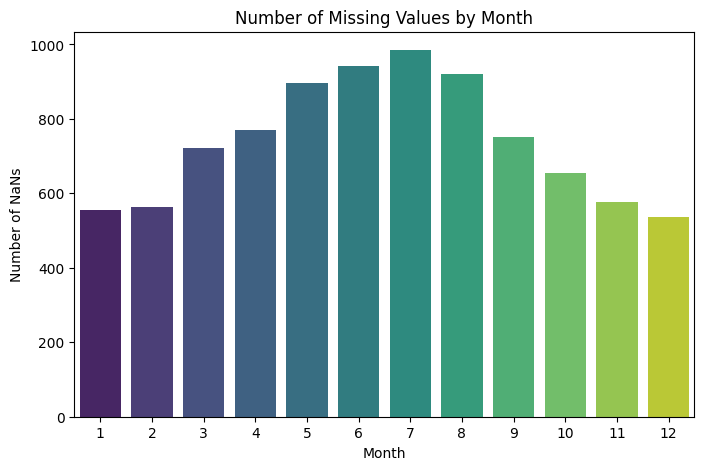

In [78]:
plt.figure(figsize=(8, 5))
sns.barplot(data=month_nan_count, x='month', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by Month')
plt.xlabel('Month')
plt.ylabel('Number of NaNs')
plt.show()

In [75]:
dow_nan_count = train_df[train_df['num_sold'].isna()].groupby('day_of_week').size().reset_index(name='nan_count')
print(dow_nan_count.sort_values(by='nan_count', ascending=False))

   day_of_week  nan_count
0            0       1418
2            2       1418
3            3       1416
1            1       1406
4            4       1234
5            5       1087
6            6        892


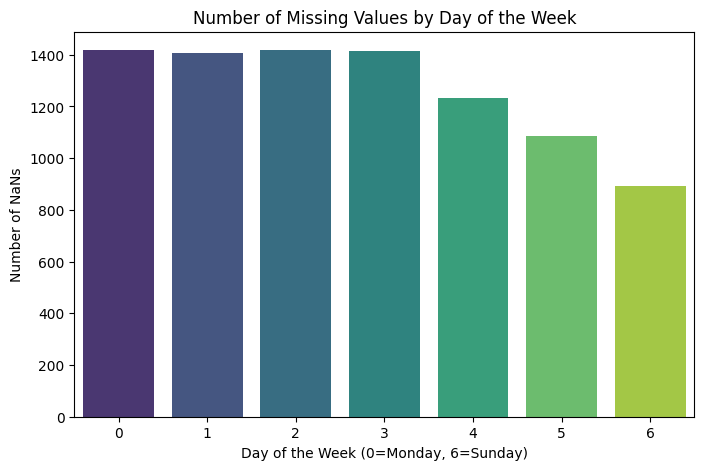

In [79]:
plt.figure(figsize=(8, 5))
sns.barplot(data=dow_nan_count, x='day_of_week', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of NaNs')
plt.show()

In [76]:
week_nan_count = train_df[train_df['num_sold'].isna()].groupby('week_of_year').size().reset_index(name='nan_count')
print(week_nan_count.sort_values(by='nan_count', ascending=False))

    week_of_year  nan_count
28            29        229
24            25        226
25            26        225
27            28        223
29            30        221
30            31        219
23            24        219
31            32        218
21            22        217
26            27        216
20            21        215
32            33        211
22            23        210
19            20        202
34            35        197
18            19        197
33            34        195
16            17        190
17            18        189
15            16        181
36            37        179
12            13        177
14            15        176
35            36        176
37            38        172
38            39        172
13            14        167
11            12        161
39            40        159
10            11        158
9             10        158
40            41        152
8              9        149
7              8        144
41            42    

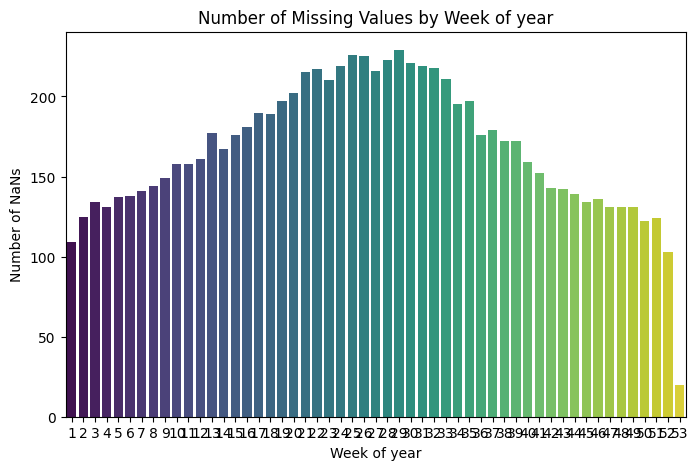

In [80]:
plt.figure(figsize=(8, 5))
sns.barplot(data=week_nan_count, x='week_of_year', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by Week of year')
plt.xlabel('Week of year')
plt.ylabel('Number of NaNs')
plt.show()

### Adding holidays

In [85]:
train_df["holidays"] = 0

In [87]:
alpha2 = dict(zip(np.sort(train_df.country.unique()), ['CA', 'FI', 'IT', 'KE', 'NO', 'SG']))
h = {c: holidays.country_holidays(a, years=range(2010, 2020)) for c, a in alpha2.items()}
for c in alpha2:
    train_df.loc[train_df.country==c, 'holidays'] = train_df.date.isin(h[c]).astype(int)

In [92]:
#groupby country and value counts of holidays
train_df.groupby('country')['holidays'].value_counts()

country    holidays
Canada     0           37755
           1             600
Finland    0           36780
           1            1575
Italy      0           37095
           1            1260
Kenya      0           37275
           1            1080
Norway     0           37110
           1            1245
Singapore  0           36990
           1            1365
Name: count, dtype: int64

In [93]:
holiday_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('holidays').size().reset_index(name='nan_count')
print(holiday_nan_analysis)

   holidays  nan_count
0         0       8694
1         1        177


In [38]:
#line graph of num sold average monthly over every month of date
monthly_avg = train_df.groupby(train_df['date'].dt.to_period('M')).mean().reset_index()
monthly_avg['date'] = monthly_avg['date'].dt.to_timestamp()

# Plot the line graph
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg, x='date', y='num_sold')
plt.xlabel('Date')
plt.ylabel('Average Num Sold')
plt.title('Average Monthly Sticker Sales')
plt.grid(True)
plt.show()


TypeError: agg function failed [how->mean,dtype->object]